# Predicting Credit Card Default
**Group F**: Chi Xue, Jingting Yan, Nicolas Ford, To Eun Kim, Xiaoqi Tan, Zi Lian Lim
<br>
January 10, 2021

# **1. Introduction**

# **2. Data Import** 

### 2.1 Library Imports

Install packages in conda environments.

In [155]:
conda install -c anaconda scikit-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Note that in this notebook, the **0.5.0** version of imblearn is required:

In [22]:
conda install -c conda-forge imbalanced-learn==0.5.0

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - imbalanced-learn==0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imbalanced-learn-0.5.0     |             py_0          98 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          98 KB

The following packages will be DOWNGRADED:

  imbalanced-learn                               0.7.0-py_0 --> 0.5.0-py_0



imbalanced-learn-0.5 | 98 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: | WARNING conda.core.path_actions:verify(963): Unable to create environments file. Path not writable.
  environment location: /Users/yangent/.conda/environments.txt

In [26]:
conda install -c conda-forge tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [27]:
conda install -c conda-forge keras

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [28]:
conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import io
import time

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from numpy import where
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense

import xgboost as xgb
from xgboost import XGBClassifier

Using TensorFlow backend.


### 2.2 Load datasets
Simply modify the data path to load your data.

In [15]:
# Data paths setting
path = 'data/' # change to your local file location
train_data_path = path + 'CreditCard_train.csv'
test_data_path = path + 'CreditCard_test.csv'  

In [16]:
# pass the second line in the CSV file as column names
df_train = pd.read_csv(train_data_path, header=1)
df_test = pd.read_csv(test_data_path, header=1)

In [17]:
df_train.rename(columns={'PAY_0':'PAY_1'}, inplace=True) # change strange (inconsistent) column name 'PAY_0'
df_train.rename(columns={'default payment next month':'default'}, inplace=True) # shorten the name of the target column
df_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,23996,80000,1,2,1,25,1,2,2,0,...,80215,63296,49854,3800,6,3636,2646,2000,1830,0
23996,23997,20000,1,2,1,25,0,0,0,0,...,17322,17119,17350,1552,2659,1419,606,500,1000,0
23997,23998,10000,1,2,2,26,0,0,0,0,...,17506,16608,9176,1300,2200,1300,320,1820,1000,0
23998,23999,20000,1,5,2,26,0,0,0,0,...,39950,0,0,3055,1467,1096,1000,0,0,0


In [18]:
# check the ratio of train-test split
print('train:', df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]))
print('test:', df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]))

train: 0.8
test: 0.2


Train-test-split is 8:2.

# **3. Data Exploration and Transformation**
This section contains four parts: 1) Data Exploration; 2) Data Cleaning; 3) Exploratory Data Analysis; 4) Feature Engineering.

### 3.1 Data Exploration
1. Check missing values.
2. Check if labels in categorical variables are all documented.
3. Check if outliers existed in numerical variables: a) negative values; b) extreme values.
4. Investigate whether the training set is balanced (ratio of 'default').

**3.1.1 Check missing values**

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         24000 non-null  int64
 1   LIMIT_BAL  24000 non-null  int64
 2   SEX        24000 non-null  int64
 3   EDUCATION  24000 non-null  int64
 4   MARRIAGE   24000 non-null  int64
 5   AGE        24000 non-null  int64
 6   PAY_1      24000 non-null  int64
 7   PAY_2      24000 non-null  int64
 8   PAY_3      24000 non-null  int64
 9   PAY_4      24000 non-null  int64
 10  PAY_5      24000 non-null  int64
 11  PAY_6      24000 non-null  int64
 12  BILL_AMT1  24000 non-null  int64
 13  BILL_AMT2  24000 non-null  int64
 14  BILL_AMT3  24000 non-null  int64
 15  BILL_AMT4  24000 non-null  int64
 16  BILL_AMT5  24000 non-null  int64
 17  BILL_AMT6  24000 non-null  int64
 18  PAY_AMT1   24000 non-null  int64
 19  PAY_AMT2   24000 non-null  int64
 20  PAY_AMT3   24000 non-null  int64
 21  PAY_AMT4   2

No Missing Values. All variables have numerical values (int64).

**3.1.2 Check undocumented labels**

In [40]:
# check if the values of categorical variable in training set are well-documented
print('SEX:', sorted(df_train['SEX'].unique()))
print('EDUCATION:', sorted(df_train['EDUCATION'].unique()))
print('MARRIAGE:', sorted(df_train['MARRIAGE'].unique()))
print('PAY_1:', sorted(df_train['PAY_1'].unique()))
print('PAY_2:', sorted(df_train['PAY_2'].unique()))
print('PAY_3:', sorted(df_train['PAY_3'].unique()))
print('PAY_4:', sorted(df_train['PAY_4'].unique()))
print('PAY_5:', sorted(df_train['PAY_5'].unique()))
print('PAY_6:', sorted(df_train['PAY_6'].unique()))
print('default:', sorted(df_train['default'].unique()))

SEX: [1, 2]
EDUCATION: [0, 1, 2, 3, 4, 5, 6]
MARRIAGE: [0, 1, 2, 3]
PAY_1: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_2: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_3: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_4: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_5: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
PAY_6: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
default: [0, 1]


Undocumented categories existed in the training set:
- EDUCATION: 0, 5, 6  
- MARRIAGE: 0  
- PAY_1 to PAY_6: -2, 0

In [41]:
# Count the number of rows for each undocumented label
undocumented_labels = ['EDUCATION == 0','EDUCATION == 5','EDUCATION == 6','MARRIAGE == 0','PAY_n == -2', 'PAY_n == 0']
counts = pd.DataFrame(index=undocumented_labels, columns=['Training'])

# EDUCATION, training set
counts.loc['EDUCATION == 0', 'Training'] = df_train[df_train['EDUCATION'] == 0].shape[0]
counts.loc['EDUCATION == 5', 'Training'] = df_train[df_train['EDUCATION'] == 5].shape[0]
counts.loc['EDUCATION == 6', 'Training'] = df_train[df_train['EDUCATION'] == 6].shape[0]

# MARRIAGE, training set
counts.loc['MARRIAGE == 0', 'Training'] = df_train[df_train['MARRIAGE'] == 0].shape[0]

# PAY_1 to PAY_6, training set
counts.loc['PAY_n == -2', 'Training'] = df_train[(df_train['PAY_1'] == -2) | (df_train['PAY_2'] == -2) | 
                                                 (df_train['PAY_3'] == -2) | (df_train['PAY_4'] == -2) | 
                                                 (df_train['PAY_5'] == -2) | (df_train['PAY_6'] == -2)].shape[0]
counts.loc['PAY_n == 0', 'Training'] = df_train[(df_train['PAY_1'] == 0) | (df_train['PAY_2'] == 0) | 
                                                (df_train['PAY_3'] == 0) | (df_train['PAY_4'] == 0) | 
                                                (df_train['PAY_5'] == 0) | (df_train['PAY_6'] == 0)].shape[0]

counts

,Training
EDUCATION == 0,11
EDUCATION == 5,207
EDUCATION == 6,37
MARRIAGE == 0,41
PAY_n == -2,5185
PAY_n == 0,16929


**Solution:** *(will be dealt in the **Data Cleaning** phase)*
- EDUCATION: categorise 0, 5, 6 as 4 (*others*)  
*others* may refer to education level either higher than graduate school or lower than high school.  
- MARRIAGE: categorise 0 as 3 (*others*)  
- PAY_1 to PAY_6: keep -2 and categorise 0 as -1 (*pay duly*)

**3.1.3 Check outliers in numerical variables**

**Check negative values**

In [44]:
numerical_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
# numerical features description
df_train[numerical_features].describe()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000
mean,165495.986667,50596.884708,48646.064125,4.636706e+04,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042
std,129128.744855,72649.374256,70364.600436,6.819390e+04,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990
min,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,3631.500000,3098.500000,2.773500e+03,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000
50%,140000.000000,22330.000000,21339.000000,2.003900e+04,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000
75%,240000.000000,65779.500000,62761.250000,5.929800e+04,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000
max,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000


In [43]:
print('Negative BILL_AMT in training set:', df_train[(df_train['BILL_AMT1'] < 0) | (df_train['BILL_AMT2'] < 0) |
                                                     (df_train['BILL_AMT3'] < 0) | (df_train['BILL_AMT4'] < 0) |
                                                     (df_train['BILL_AMT5'] < 0) | (df_train['BILL_AMT6'] < 0)].shape[0])

Negative BILL_AMT in training set: 1496


There are negative values for bill statement in training set (1496 rows).
We are not going to convert negatives to zero.

**Check extremely large or small values**
<br><br>
LIMIT_BAL, BILL_AMT and PAY_AMT all have a very broad range. Need to check if these are outliers.
<br>
**Method:** Check if the amount of previous payment (PAY_AMT) & bill statement (BILL_AMT) lie within the 'sensible' range of given credit (LIMIT_BAL). Choose LIMIT_BAL values below 5th percentile or above 95th percentile to check.

In [46]:
# investigate the percentiles for LIMIT_BAL, PAY_AMT and BILL_AMT
percentiles = []
for var in numerical_features:
    percentiles.append(list(np.percentile(df_train[var], i) for i in range(5,100,10)))

pd.DataFrame(data=percentiles, index=numerical_features, columns=['5th','15th','25th','35th','45th','55th','65th','75th','85th','95th'])

,5th,15th,25th,35th,45th,55th,65th,75th,85th,95th
LIMIT_BAL,20000.0,50000.00,50000.00,80000.00,120000.00,150000.00,200000.00,240000.00,300000.00,430000.00
BILL_AMT1,0.0,815.00,3631.50,9245.90,17706.20,28347.00,46009.85,65779.50,105939.05,197600.00
BILL_AMT2,0.0,495.00,3098.50,8760.30,17385.00,27619.45,43981.00,62761.25,101462.40,191542.10
BILL_AMT3,0.0,390.00,2773.50,8600.55,16985.55,26011.90,40181.05,59298.00,97224.80,184792.90
BILL_AMT4,0.0,370.85,2340.00,7851.95,15528.55,22497.40,33408.05,52188.50,89414.40,171381.90
BILL_AMT5,0.0,225.00,1740.00,6805.65,14111.55,20328.45,30177.00,49746.50,84116.30,164724.15
BILL_AMT6,0.0,0.00,1234.75,5369.65,12266.40,19826.00,29736.40,48796.25,81631.80,160588.60
PAY_AMT1,0.0,0.00,1000.00,1500.00,2000.00,2550.00,3510.40,5000.00,8000.00,18243.85
PAY_AMT2,0.0,0.00,800.00,1379.00,1885.55,2390.90,3300.00,5000.00,7784.15,19000.15
PAY_AMT3,0.0,0.00,379.00,1000.00,1424.10,2000.00,3000.00,4347.25,6800.00,16513.55


In [47]:
# Check outliers: 
# 1. Select the rows where the LIMIT_BAL value is below 5th percentile or above 95th percentile. 
# 2. Regard LIMIT_BAL as the credit base, check the rows where BILL_AMT or PAY_EMT exceed 2 * LIMIT_BAL

data = df_train[(df_train['LIMIT_BAL'] < np.percentile(df_train['LIMIT_BAL'], 5)) | 
                (df_train['LIMIT_BAL'] > np.percentile(df_train['LIMIT_BAL'], 95))][numerical_features]
    
data_out_of_range = []

for i in data.index.values.tolist():
    limit_bal = df_train.loc[i, 'LIMIT_BAL']
    upper_limit = 2 * limit_bal

    if (upper_limit < df_train.loc[i, 'BILL_AMT1']) | (upper_limit < df_train.loc[i, 'BILL_AMT2']) |\
       (upper_limit < df_train.loc[i, 'BILL_AMT3']) | (upper_limit < df_train.loc[i, 'BILL_AMT4']) |\
       (upper_limit < df_train.loc[i, 'BILL_AMT5']) | (upper_limit < df_train.loc[i, 'BILL_AMT6']) |\
       (upper_limit < df_train.loc[i, 'PAY_AMT1']) | (upper_limit < df_train.loc[i, 'PAY_AMT2']) |\
       (upper_limit < df_train.loc[i, 'PAY_AMT3']) | (upper_limit < df_train.loc[i, 'PAY_AMT4']) |\
       (upper_limit < df_train.loc[i, 'PAY_AMT5']) | (upper_limit < df_train.loc[i, 'PAY_AMT6']):
            data_out_of_range.append(i)
    
print('Number of outliers:', len(data_out_of_range))
outliers = df_train.loc[data_out_of_range, numerical_features].sort_values(by=['LIMIT_BAL'])
outliers

Number of outliers: 5


,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
5843,10000,885,1475,780,390,780,390,1475,780,0,31250,0,0
7508,10000,53095,54562,5428,7928,6091,0,2134,1000,2500,122,0,0
7688,10000,219,9110,9797,-10433,9767,9067,10400,1000,0,20200,200,0
16504,10000,8525,5141,5239,7911,17890,10000,1500,5000,4000,2000,22400,0
5296,500000,125,-18088,1664089,121757,97115,377217,4366,1684259,121831,97670,379267,26759


5 records were filtered out. In these records, either one of the previous payments or one of the bill statements or both exceeded the twice of the range of their given credit. 
<br>However, if we take a closer look at these records, we will notice that the previous payments and the bill statements are relatively balanced in general and most of their values lied with in the given credit. **Therefore, we cannot regard them as anomalies.**

**3.1.4 Check the balance of the training set**

0.22375


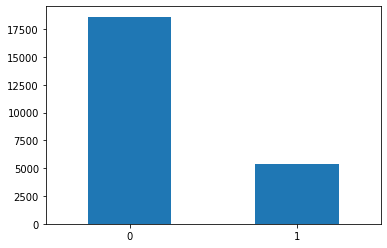

In [60]:
# calculate the ratio of 'default' in the training set
print(df_train['default'].sum() / len(df_train['default']))

df_train['default'].value_counts().plot.bar(rot=0)

22% Default, 78% No default in the training set. Therefore, **our dataset is imbalanced**.

### 3.2 Data Cleaning

In [19]:
def rename_columns(df):
    # change strange (inconsistent) column name 'PAY_0'
    df = df.rename(columns={'PAY_0':'PAY_1'})
    # shorten the name of the target column
    df = df.rename(columns={'default payment next month':'default'})
    return df

# deal with undocumented Education labels
def clean_edu(df):
    df.loc[(df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6), 'EDUCATION'] = 4
    return df

# deal with undocumented Marriage labels
def clean_marriage(df):
    df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3
    return df

# deal with undocumented past payments labels
def clean_pay(df):
    for i in range(1, 7):
        df.loc[(df[f'PAY_{i}'] == 0), f'PAY_{i}'] = -1
    return df

In [20]:
def cleaning_pipline(df):
    """
    Available functions:
    rename_pay, clean_edu, clean_marriage, clean_pay
    """
    for func in [rename_columns, clean_edu, clean_marriage, clean_pay]:
        df = func(df)
    
    print("Cleaned Data")
    return df

In [21]:
transformed_train = cleaning_pipline(df_train)
transformed_test = cleaning_pipline(df_test)

Cleaned Data
Cleaned Data


### 3.3 Exploratory Data Analysis
1. Draw bar charts to investigate categorical variables (SEX, MARRIAGE, EDUCATION). 
<br>See how the training dataset is divided and if there are sparse classes which can cause overfit of the model.
2. Draw histograms to investigate numerical variables (LIMIT_BAL, AGE, BILL_AMT, PAY_AMT). 
<br>Check the distribution and the presence of extreme values.
3. Draw box plots and heatmapes to investigate features correlations.
4. Features importance test. 

**3.3.1 Check categorical variable's distribution (with bar charts)**

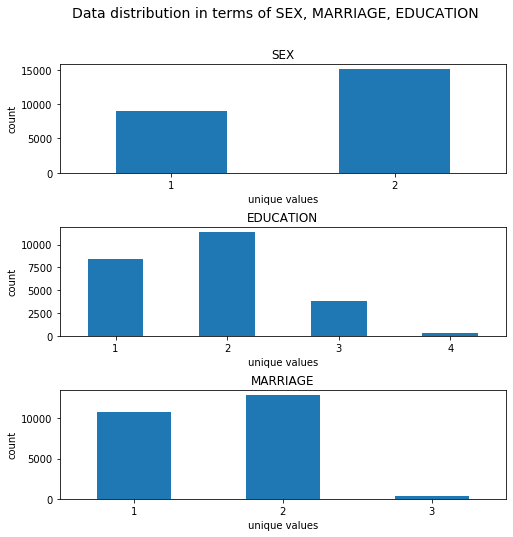

In [105]:
fig, axes = plt.subplots(nrows=3, figsize=(8,8))
fig.suptitle('Data distribution in terms of SEX, MARRIAGE, EDUCATION', fontsize=14)

transformed_train['SEX'].value_counts().sort_index().plot.bar(ax=axes[0], rot=0)
transformed_train['EDUCATION'].value_counts().sort_index().plot.bar(ax=axes[1], rot=0)
transformed_train['MARRIAGE'].value_counts().sort_index().plot.bar(ax=axes[2], rot=0)
axes[0].set_title('SEX')
axes[1].set_title('EDUCATION')
axes[2].set_title('MARRIAGE')

for ax in axes.flat:
    ax.set(xlabel='unique values', ylabel='count')

plt.subplots_adjust(hspace=0.5)
plt.show()

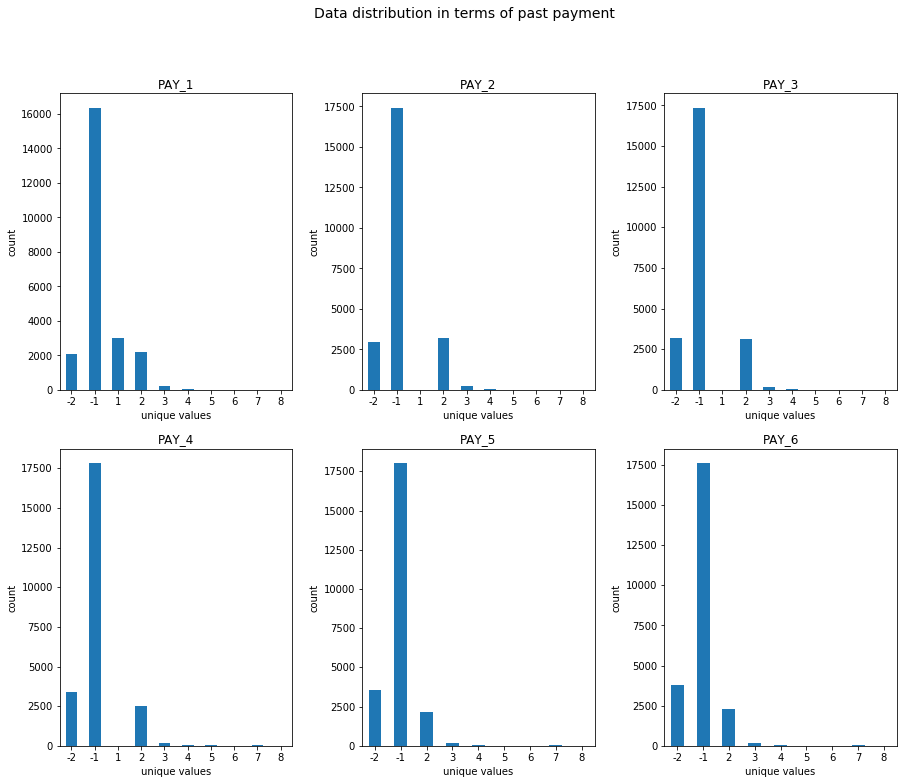

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
fig.suptitle('Data distribution in terms of past payment', fontsize=14)

transformed_train['PAY_1'].value_counts().sort_index().plot.bar(ax=axes[0,0], rot=0)
transformed_train['PAY_2'].value_counts().sort_index().plot.bar(ax=axes[0,1], rot=0)
transformed_train['PAY_3'].value_counts().sort_index().plot.bar(ax=axes[0,2], rot=0)
transformed_train['PAY_4'].value_counts().sort_index().plot.bar(ax=axes[1,0], rot=0)
transformed_train['PAY_5'].value_counts().sort_index().plot.bar(ax=axes[1,1], rot=0)
transformed_train['PAY_6'].value_counts().sort_index().plot.bar(ax=axes[1,2], rot=0)

axes[0,0].set_title('PAY_1')
axes[0,1].set_title('PAY_2')
axes[0,2].set_title('PAY_3')
axes[1,0].set_title('PAY_4')
axes[1,1].set_title('PAY_5')
axes[1,2].set_title('PAY_6')

for ax in axes.flat:
    ax.set(xlabel='unique values', ylabel='count')

plt.subplots_adjust(hspace=0.2, wspace=0.3)
plt.show()

Observations: In general, no extreme distribution in meaningful SEX, MARRIAGE, EDUCATION labels (i.e. apart from *others*). So they won't cause overfit of the model.
- More females than males.
- More graduate school and university education level than high school.
- Less frequent the *other* status is in Marriage.


However, the majority of past payments is *pay duly*, which aligns with the imbalanced nature of our training set. We would deal with this at a later stage.

**3.3.2 Check numerical variable's distribution (with histograms)**

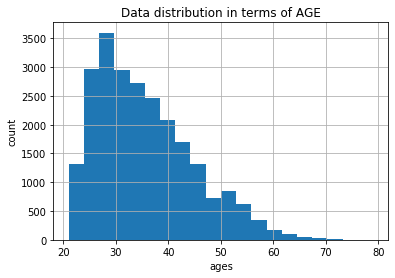

In [107]:
ax = transformed_train['AGE'].hist(bins=20)
ax.set(xlabel='ages', ylabel='count')
plt.title('Data distribution in terms of AGE')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


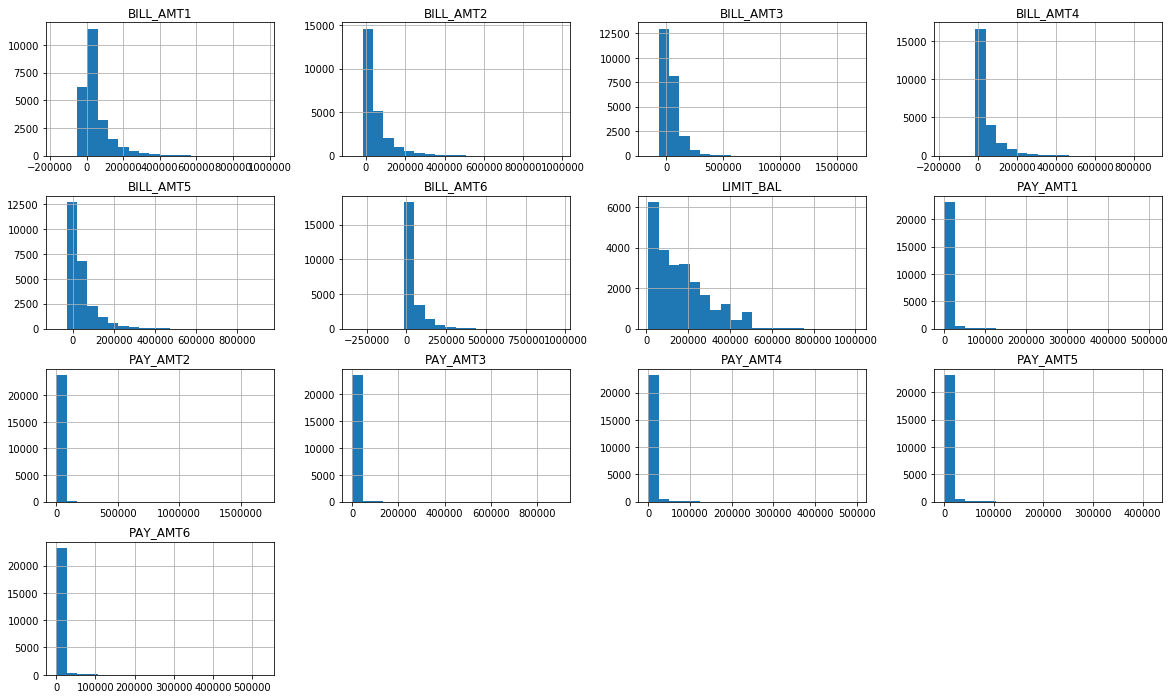

In [108]:
fig= plt.figure(figsize=(20,12))
ax = fig.gca()
fig.suptitle('Data distribution in terms of bill statements (BILL_AMT), credit (LIMIT_BAL) and previous payments (PAY_AMT)', fontsize=14)

transformed_train[numerical_features].hist(ax=ax, bins=20)
plt.show()

Observations:
- No extreme distribution existed in AGE.
- LIMIT_BAL, BILL_AMT and PAY_AMT all have a few extremely large values. These values have been checked in **Data Exploration** phase to be treated as normal data points.

**3.3.3 Check features correlation (with box plot and heatmaps)**

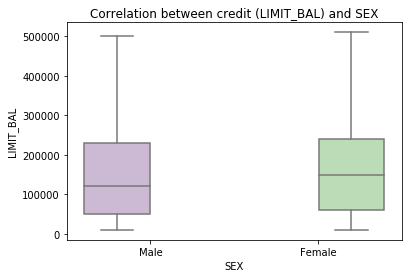

In [110]:
# check given credit vs. sex
ax = sns.boxplot(x="SEX", y="LIMIT_BAL", hue="SEX", data=transformed_train, palette="PRGn",showfliers=False)
ax.legend_.remove()
ax.set_title('Correlation between credit (LIMIT_BAL) and SEX')

# interpret the unique values in xticks
xlabels = [item.get_text() for item in ax.get_xticklabels()]
sex_encoder = {'1':'Male', '2':'Female'}
xlabels = [sex_encoder.get(xlabels[i]) for i in range(len(xlabels))]
ax.set_xticklabels(xlabels)

plt.show()

Observations: The given credit is quite balanced between sexes. Males have a slightly smaller Q1 and mean.

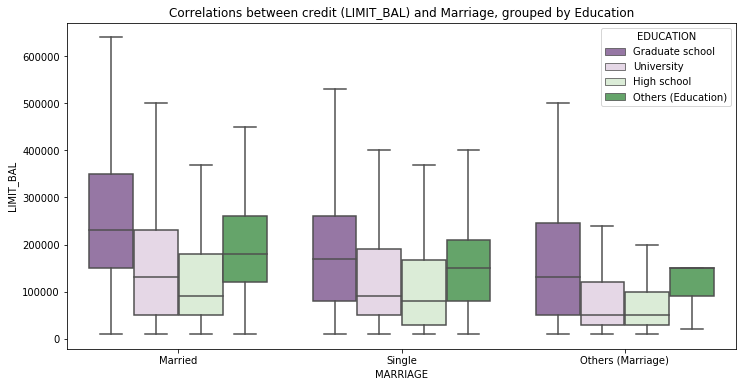

In [118]:
# credit grouped by marriage status and education level
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(ax=ax, x='MARRIAGE', y='LIMIT_BAL', hue='EDUCATION', data=transformed_train, palette="PRGn",showfliers=False)

# interpret the unique values (of EDUCATION) in legend
education_encoder = {'1':'Graduate school', '2':'University', '3':'High school', '4': 'Others (Education)'}
L = plt.legend()
L.set_title('EDUCATION')
for i in range(len(L.get_texts())):
    legend_text = L.get_texts()[i].get_text()
    L.get_texts()[i].set_text(education_encoder.get(legend_text))

# interpret the unique values (of MARRIAGE) in xticks
xlabels = [item.get_text() for item in ax.get_xticklabels()]
marriage_encoder = {'1':'Married', '2':'Single', '3':'Others (Marriage)'}
xlabels = [marriage_encoder.get(xlabels[i]) for i in range(len(xlabels))]
ax.set_xticklabels(xlabels)

plt.title('Correlations between credit (LIMIT_BAL) and Marriage, grouped by Education')
plt.show()

Observations: In general, higher education level has higher credit among all marriage groups. Married people have higher credit than Single than Others among all education levels.

In [111]:
# plot heatmap for a certain set of numerical variables
def check_correlation(variables, title:str):
    plt.figure(figsize=(10,8))
    plt.title(title + ' (Apr 2005 to Sep 2005)' + '\nCorrelation Plot')
    corr = transformed_train[variables].corr()
    sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
    plt.show()

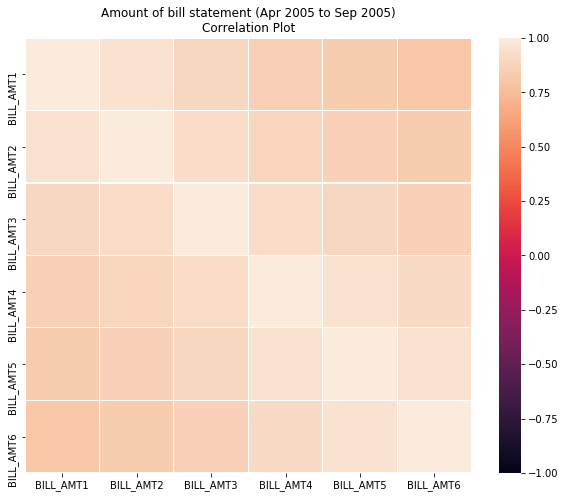

In [112]:
# check the correlation between bill statements
check_correlation(['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], 'Amount of bill statement')

Observations: Correlation is decreasing as the distance between months increases. The lowest correlation is between Sept (BILL_AMT1) & April (BILL_AMT6).

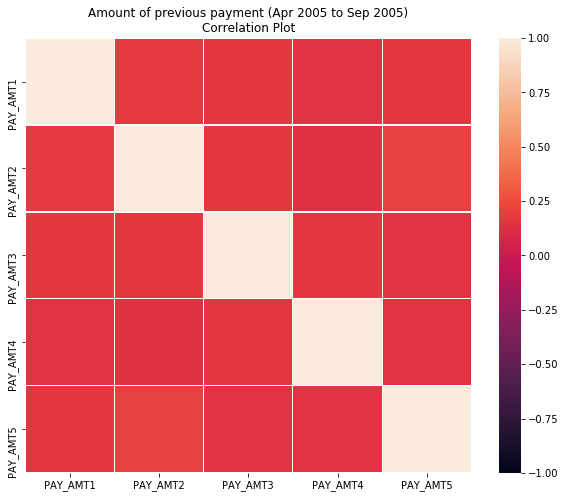

In [113]:
# check the correlation betwee previous payments
check_correlation(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5'], 'Amount of previous payment')

Observations: There are no obvious correlations between the amounts of previous payments.

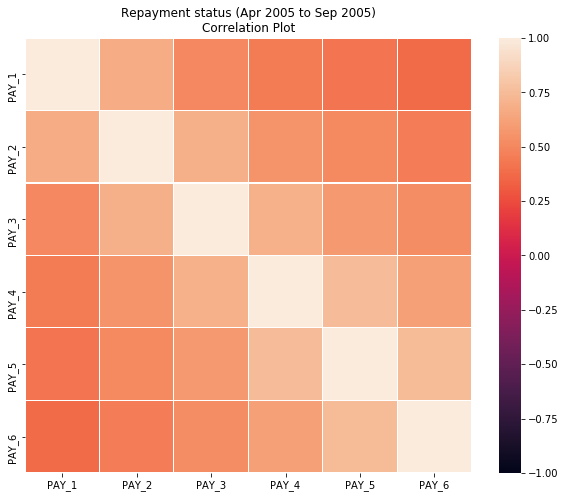

In [114]:
# check the correlation between Repayment status
check_correlation(['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], 'Repayment status')

Observations: Correlation is decreasing as the distance between months increases. The lowest correlation is between Sept (BILL_AMT1) & April (BILL_AMT6). **The repayment status and the bill statements have a similar distribution.**

**3.3.4 Features Importance Test**
<br>Use of any classification model and feed raw data without any splitting and cross validation. This is purely to get a general understanding of importance of features and to set a certain goal for data transformation as part of exploration.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


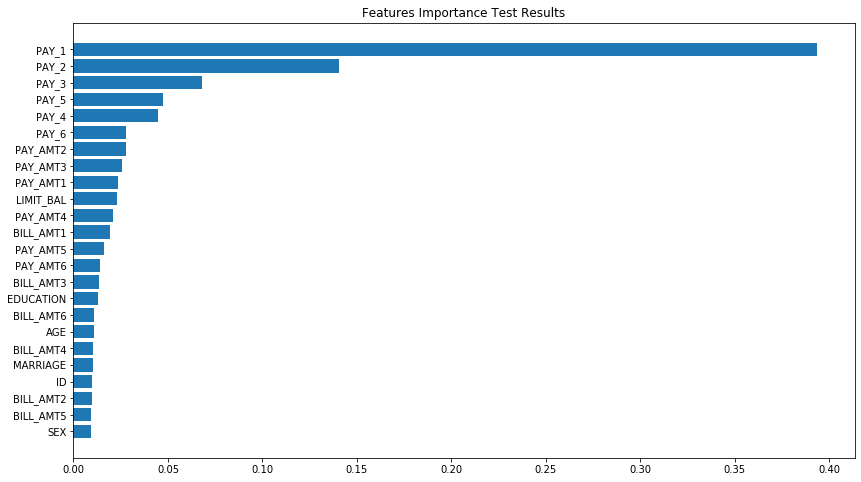

In [119]:
# split training data into X and y
X = transformed_train.drop(['default'], axis=1)
y = transformed_train[['default']]

# fit model with training data
model = XGBClassifier()
model.fit(X, y)

# Get feature name place number
features_num = [i for i in range(len(model.feature_importances_))]
importance = model.feature_importances_.tolist()
feature_names = X.columns

# Sorting
matched = zip(features_num, feature_names, importance)
sorted_importance = sorted(matched, key=lambda x: x[2])       # sort by importance

sorted_features_importance = list(map(lambda x: x[2], sorted_importance))
sorted_features_names = list(map(lambda x: x[1], sorted_importance))

fig = plt.figure(figsize=(14, 8))
plt.barh(features_num, sorted_features_importance, tick_label=sorted_features_names)
plt.title('Features Importance Test Results')
plt.show()

Observations:
1. PAY_N is the most important feature, so we will not change these features during transformation phase.
2. Generally, PAY_N > PAY_AMT >LIMIT_BAL > BILL_AMT. Therefore we can try to use BILL_AMTs and try making stronger and semantically meaningful features by combining weak features.
3. Among 4 personal information (*Education, Marriage, Age, Sex*), Education is the most important feature. On the other hand, Marriage, Age & Sex are contributing very little to the classification. 

### 3.4 Feature Engineering
In this section, we conducted feature engineering based on the insights obtained from **Exploratory Data Analysis**. It contains three main parts of transformation: 1) feature processing; 2) remedy for imbalanced training set using **Borerline-SMOTE**; 3) feature scaling.

**3.4.1 Feature processing**

In [22]:
def drop_id(df):
    df = df.drop(['ID'], axis=1)
    return df

# combine SEX and MARRIAGE, encode each unique combination with an integer values [1,6]
# this can reduce the dimension of the dataset
def combine_gender_marital(df):
    df['SEX_MAR'] = 0  # placeholder for integer values
    # encoding
    df.loc[(df['SEX'] == 1) & (df['MARRIAGE'] == 1), 'SEX_MAR'] = 1
    df.loc[(df['SEX'] == 1) & (df['MARRIAGE'] == 2), 'SEX_MAR'] = 2
    df.loc[(df['SEX'] == 1) & (df['MARRIAGE'] == 3), 'SEX_MAR'] = 3
    df.loc[(df['SEX'] == 2) & (df['MARRIAGE'] == 1), 'SEX_MAR'] = 4
    df.loc[(df['SEX'] == 2) & (df['MARRIAGE'] == 2), 'SEX_MAR'] = 5
    df.loc[(df['SEX'] == 2) & (df['MARRIAGE'] == 3), 'SEX_MAR'] = 6
    
    df = df.drop(['SEX', 'MARRIAGE'], axis=1)
    print('combined gender & marital')
    return df

# further categorise ages in step 10
def make_age_bins(df):
    df['AgeBin'] = 0 # placeholder for integer values
    df.loc[((df['AGE'] < 30)) , 'AgeBin'] = 1
    df.loc[((df['AGE'] >= 30) & (df['AGE'] < 40)) , 'AgeBin'] = 2
    df.loc[((df['AGE'] >= 40) & (df['AGE'] < 50)) , 'AgeBin'] = 3
    df.loc[((df['AGE'] >= 50) & (df['AGE'] < 60)) , 'AgeBin'] = 4
    df.loc[((df['AGE'] >= 60) & (df['AGE'] < 70)) , 'AgeBin'] = 5
    df.loc[((df['AGE'] >= 70) & (df['AGE'] < 81)) , 'AgeBin'] = 6
    
    df = df.drop(['AGE'], axis=1)
    print('made age bins')
    return df

# create 6 new features, 'Closeness_1' to 'Closeness_6', which calculates the difference 
# between credit (LIMIT_BAL) and each bill statement.
def get_closeness(df):
    for i in range(1, 7):
        df[f'Closeness_{i}'] = (df.LIMIT_BAL - df[f'BILL_AMT{i}']) #/ df.LIMIT_BAL
    
    print('added closeness')
    return df

# create a new feature called 'diff' that calculates the difference between the sum of 
# bill statements (BIL_AMT1 to BIL_AMT6) and the sum of previous payments (PAY_AMT1 to PAY_AMT6)
def get_diff_of_totals(df):
    df['diff'] = 0   # placeholder for integer values
    
    bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
    pay_cols = [f'PAY_AMT{i}' for i in range(1, 7)]
    
    for index, row in df.iterrows():
        bill_df = df.loc[index, bill_cols]
        pay_df = df.loc[index, pay_cols]

        bill_sum = np.sum(bill_df.values)
        pay_sum = np.sum(pay_df.values)

        df.loc[index, 'diff'] = bill_sum - pay_sum
    
    print('added diff')
    return df

def drop_bill_amt(df):
    df = df.drop([f'BILL_AMT{i}' for i in range(1, 7)], axis=1)
    return df

def drop_pay_amt(df):
    df = df.drop([f'PAY_AMT{i}' for i in range(1, 7)], axis=1)
    return df

def drop_age(df):
    df = df.drop(['AGE'], axis=1)
    return df

In [23]:
def processing_pipline(df):
    """
    Available functions:
    drop_id, combine_gender_marital, make_age_bins, get_closeness, get_diff_of_totals, drop_bill_amt, drop_pay_amt, drop_age
    """
    for func in [drop_id, combine_gender_marital, make_age_bins, get_closeness, get_diff_of_totals]:
        df = func(df)
    
    print("Transformed Features")
    
    return df

In [24]:
transformed_train = processing_pipline(transformed_train)
transformed_test = processing_pipline(transformed_test)

combined gender & marital
made age bins
added closeness
added diff
Transformed Features
combined gender & marital
made age bins
added closeness
added diff
Transformed Features


### 3.4.2 Dealing with an imabalanced dataset
The training set is imbalanced since the ratio of Default to No Default is about 2:8. We adopted the SMOTE oversampling technique for remedy.
<br>Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

**SMOTE vs. Borderline-SMOTE**
<br>We first generalised an imbalanced classes with 2 features to compare the performance of  **SMOTE** and **Borderline-SMOTE**.

Counter({0: 9900, 1: 100})


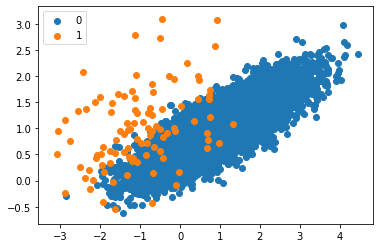

In [19]:
# Simulated data with 10000 samples and the radio of 0 and 1 is 0.99.
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Counter({0: 9900, 1: 9900})


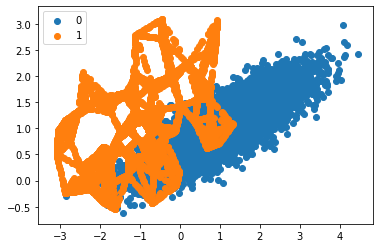

In [20]:
# Handle the data by using SMOTE method and plot the scatter graph
oversample = SMOTE()
X_test_smote, y_test_smote = oversample.fit_sample(X, y)
counter = Counter(y_test_smote)
print(counter)

for label, _ in counter.items():
    row_ix = where(y_test_smote == label)[0]
    plt.scatter(X_test_smote[row_ix, 0], X_test_smote[row_ix, 1], label=str(label))
plt.legend()
plt.show()

From the graph, we can observe that all the minority samples are used to generate new synthetic data.

To improve the algorithm, we use Boarderline-SMOTE to regenerate the syntnetic samples:


Counter({0: 9900, 1: 9900})


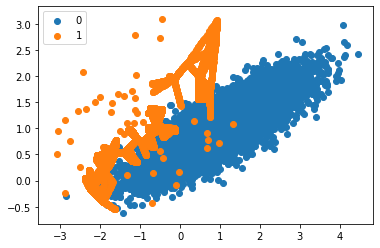

In [21]:
oversample = BorderlineSMOTE(random_state=42, kind="borderline-1")
X_test_BS, y_test_BS = oversample.fit_sample(X, y)
counter = Counter(y_test_BS)
print(counter)

for label, _ in counter.items():
    row_ix = where(y_test_BS == label)[0]
    plt.scatter(X_test_BS[row_ix, 0], X_test_BS[row_ix, 1], label=str(label))
plt.legend()
plt.show()

After applying Borderline-SMOTE, minorty samples which are far away from the decision boundary are not taken to generate new synthetic samples. Minority samples which are overlapped with the majority samples are not used to generate new synthetic samples as well. 

As a result, **we decided to apply borderline-SMOTE on Credit Card Default data**:

In [25]:
# borderline_SMOTE provided data with less probability to overfit
def Borderline_SMOTE(df):
    oversample = BorderlineSMOTE(random_state=42, kind="borderline-1")
    y_train = df['default'].copy()
    X_train = df.copy()
    X_train = X_train.drop(['default'], axis = 1)
    
    X_borderline_smote, y_borderline_smote = oversample.fit_sample(X_train, y_train)
    counter = Counter(y_borderline_smote)
    print(counter)
    print("Probability of default is 1: ", y_borderline_smote.sum() / len(y_borderline_smote))
    
    return X_borderline_smote, y_borderline_smote

In [26]:
X_train_oversampled, y_train_oversampled = Borderline_SMOTE(transformed_train)
print("X_train_oversampled shape:", X_train_oversampled.shape)
print("y_train_oversampled shape:", y_train_oversampled.shape)

Counter({1: 18630, 0: 18630})
Probability of default is 1:  0.5
X_train_oversampled shape: (37260, 29)
y_train_oversampled shape: (37260,)


Now, the ratio of Default is balanced. We obtained 37260 samples for training.

### 3.4.3 Feature scaling: Normalisation or Standardization
NOTE: Feature scaling of training data has to be done with test data with the same scale.
<br> Set up 2 sets of training & test data: 1) SMOTEd version; 2) non-SMOTEd version.

In [28]:
# split target column
x_train = transformed_train.copy()
x_train = x_train.drop(['default'], axis = 1)
y_train = transformed_train['default'].copy()

x_test = transformed_test.copy()
x_test = x_test.drop(['default'], axis = 1)
y_test = transformed_test['default'].copy()

In [31]:
# scaling non-SMOTEd training & test data
scaler = MinMaxScaler().fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)

print("x_train has shape", x_train.shape)
print("y_train has shape", y_train.shape)
print("x_test has shape", x_test.shape)
print("y_test has shape", y_test.shape)

x_train has shape (24000, 29)
y_train has shape (24000,)
x_test has shape (6000, 29)
y_test has shape (6000,)


In [34]:
# scaling SMOTEd training & test data
scaler_oversampled = MinMaxScaler().fit(X_train_oversampled)
x_train_oversampled, x_test_oversampled = scaler_oversampled.transform(X_train_oversampled), scaler_oversampled.transform(x_test)

print("x_train_oversampled has shape", x_train_oversampled.shape)
print("y_train_oversampled has shape", y_train_oversampled.shape)
print("x_test_oversampled has shape", x_test_oversampled.shape)

x_train_oversampled has shape (37260, 29)
y_train_oversampled has shape (37260,)
x_test_oversampled has shape (6000, 29)


# **4. Methodology**

In this section, we tried 5 different methodologies from three main categories: Decision Trees(**AdaBoost**, **XGBoost** and **Gradient Boosting**), **Random Forest** and **Artificial Neural Networks**. For each methodology, we trained a oversampled and non-oversampled version (10 models in total). The evaluation metrics used to compare the prediction performances are: **accuracy score, f1 score, false positive (FP) rate and false negative (FN) rate**. Finally, we chose non-oversampled XGBoost as our final methodology.

In [33]:
# create a DataFrame to hold the evalutation results for each model
models_evals = pd.DataFrame(index=['AdaBoost (oversampled)', 'AdaBoost (non-oversampled)', 
                                   'Random Forest (oversampled)', 'Random Forest (non-oversampled)', 
                                   'GBRT (oversampled)', 'GBRT (non-oversampled)', 
                                   'ANN (oversampled)', 'ANN (non-oversampled)', 
                                   'XGBoost (oversampled)', 'XGBoost (non-oversampled)'],
                           columns=['accuracy', 'f1', 'FP rate', 'FN rate'])
models_evals

,accuracy,f1,FP rate,FN rate
AdaBoost (oversampled),NaN,NaN,NaN,NaN
AdaBoost (non-oversampled),NaN,NaN,NaN,NaN
Random Forest (oversampled),NaN,NaN,NaN,NaN
Random Forest (non-oversampled),NaN,NaN,NaN,NaN
GBRT (oversampled),NaN,NaN,NaN,NaN
GBRT (non-oversampled),NaN,NaN,NaN,NaN
ANN (oversampled),NaN,NaN,NaN,NaN
ANN (non-oversampled),NaN,NaN,NaN,NaN
XGBoost (oversampled),NaN,NaN,NaN,NaN
XGBoost (non-oversampled),NaN,NaN,NaN,NaN


In [52]:
# used in 4.1, 4.2, 4.3, 4.4, 4.5
def cal_FP_FN(y_true, y_pred):
    # compute the confusion metrix
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                      columns=['No Default', 'Default'], index = ['No Default', 'Default'])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    # FP = the number of incorrect positive predictions / the total number of negatives
    fp = cm.loc['No Default','Default']/cm.loc['No Default',:].sum()
    
    # FN = the number of incorrect negative predictions / the total number of positives
    fn = cm.loc['Default','No Default']/cm.loc['Default',:].sum()
    
    return fp, fn

In [37]:
# used in 4.1, 4.2, 4.3
def train_and_cross_validate(model, x_train, y_train, prompt, n_splits=5):
    n_iter = 1      # this var is made just to keep track of the number of iteration
    kfold = KFold(n_splits=n_splits)
    cv_accuracy = []

    for train_idx, val_idx in kfold.split(x_train):
        x_train_cv, x_val = x_train[train_idx], x_train[val_idx]
        y_train_cv, y_val = y_train[train_idx], y_train[val_idx]

        model.train(x_train_cv, y_train_cv)
        pred = model.predict(x_val)

        accuracy = np.round(accuracy_score(y_val, pred), 3)

        print("Iteration : {}, Cross-Validation Accuracy : {}".format(n_iter, accuracy))

        n_iter += 1

        cv_accuracy.append(accuracy)

    print("Average accuracy for", prompt, ":", np.mean(cv_accuracy))

## 4.1 AdaBoost

### 4.1.1 Model Training

In [38]:
class adaboost(object):
    def __init__(self):
        # build the model
        self.model = ensemble.AdaBoostClassifier(n_estimators=200,learning_rate=0.001)

    def train(self, x_train, y_train):
        # training
        self.model.fit(x_train,y_train)

    def predict(self, x_test):
        # predicting
        y_pred = self.model.predict(x_test)

        return y_pred

In [61]:
# train Adaboost model with non-oversampled data
adaboost_model = adaboost()
train_and_cross_validate(adaboost_model, x_train, y_train, "Adaboost (non-oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.805
Iteration : 2, Cross-Validation Accuracy : 0.807
Iteration : 3, Cross-Validation Accuracy : 0.812
Iteration : 4, Cross-Validation Accuracy : 0.822
Iteration : 5, Cross-Validation Accuracy : 0.838
Average accuracy for Adaboost (non-oversampled) : 0.8168000000000001


In [62]:
# train Adaboost model with oversampled data
adaboost_model_os = adaboost()
train_and_cross_validate(adaboost_model_os, x_train_oversampled, y_train_oversampled, "Adaboost (oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.766
Iteration : 2, Cross-Validation Accuracy : 0.77
Iteration : 3, Cross-Validation Accuracy : 0.79
Iteration : 4, Cross-Validation Accuracy : 0.74
Iteration : 5, Cross-Validation Accuracy : 0.722
Average accuracy for Adaboost (oversampled) : 0.7575999999999999


### **4.1.2 Results**

**Results for non-oversampled Adaboost**

In [63]:
# prediction
y_pred_adaboost = adaboost_model.predict(x_test)

# evaluation metrics
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
f1_adaboost = f1_score(y_test, y_pred_adaboost)
fp_adaboost, fn_adaboost = cal_FP_FN(y_test, y_pred_adaboost)

print(f"Accuracy score for Adaboost (non-oversampled): {accuracy_adaboost:.3f}")
print(f"f1 score for Adaboost (non-oversampled): {f1_adaboost:.3f}")
print(f"False Positive rate for Adaboost (non-oversampled): {fp_adaboost:.3f}")
print(f"False Negative rate for Adaboost (non-oversampled): {fn_adaboost:.3f}")

# store the evaluation results
models_evals.loc['AdaBoost (non-oversampled)', 'accuracy'] = round(accuracy_adaboost, 3)
models_evals.loc['AdaBoost (non-oversampled)', 'f1'] = round(f1_adaboost, 3)
models_evals.loc['AdaBoost (non-oversampled)', 'FP rate'] = round(fp_adaboost, 3)
models_evals.loc['AdaBoost (non-oversampled)', 'FN rate'] = round(fn_adaboost, 3)

Accuracy score for Adaboost (non-oversampled): 0.831
f1 score for Adaboost (non-oversampled): 0.448
False Positive rate for Adaboost (non-oversampled): 0.034
False Negative rate for Adaboost (non-oversampled): 0.675


**Results for oversampled Adaboost**

In [64]:
# prediction
y_pred_adaboost_os = adaboost_model_os.predict(x_test_oversampled)

# evaluation metrics
accuracy_adaboost_os = accuracy_score(y_test, y_pred_adaboost_os)
f1_adaboost_os = f1_score(y_test, y_pred_adaboost_os)
fp_adaboost_os, fn_adaboost_os = cal_FP_FN(y_test, y_pred_adaboost_os)

print(f"Accuracy score for Adaboost (oversampled): {accuracy_adaboost_os:.3f}")
print(f"f1 score for Adaboost (oversampled): {f1_adaboost_os:.3f}")
print(f"False Positive rate for Adaboost (oversampled): {fp_adaboost_os:.3f}")
print(f"False Negative rate for Adaboost (oversampled): {fn_adaboost_os:.3f}")

# store the evaluation results
models_evals.loc['AdaBoost (oversampled)', 'accuracy'] = round(accuracy_adaboost_os, 3)
models_evals.loc['AdaBoost (oversampled)', 'f1'] = round(f1_adaboost_os, 3)
models_evals.loc['AdaBoost (oversampled)', 'FP rate'] = round(fp_adaboost_os, 3)
models_evals.loc['AdaBoost (oversampled)', 'FN rate'] = round(fn_adaboost_os, 3)

Accuracy score for Adaboost (oversampled): 0.211
f1 score for Adaboost (oversampled): 0.348
False Positive rate for Adaboost (oversampled): 1.000
False Negative rate for Adaboost (oversampled): 0.000


## **4.2 Random Forest**

### **4.2.1 Model Traning**

In [75]:
class random_forest(object):
    def __init__(self):
        # create the model
        self.model = ensemble.BaggingClassifier(KNeighborsClassifier(), n_estimators=200, max_samples=0.5,max_features=0.5)

    def train(self,x_train,y_train):
        # training
        self.model.fit(x_train,y_train)

    def predict(self,x_test):
        # predicting
        y_pred = self.model.predict(x_test)
        return y_pred

In [76]:
# train Random Forest model with non-oversampled data
random_forest_model = random_forest()
train_and_cross_validate(random_forest_model, x_train, y_train, "Random Forest (non-oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.797
Iteration : 2, Cross-Validation Accuracy : 0.8
Iteration : 3, Cross-Validation Accuracy : 0.801
Iteration : 4, Cross-Validation Accuracy : 0.806
Iteration : 5, Cross-Validation Accuracy : 0.831
Average accuracy for Random Forest (non-oversampled) : 0.807


In [77]:
# train Random Forest model with oversampled data
random_forest_model_os = random_forest()
train_and_cross_validate(random_forest_model_os, x_train_oversampled, y_train_oversampled, "Random Forest (oversampled)")

Iteration : 1, Cross-Validation Accuracy : 0.738
Iteration : 2, Cross-Validation Accuracy : 0.753
Iteration : 3, Cross-Validation Accuracy : 0.77
Iteration : 4, Cross-Validation Accuracy : 0.87
Iteration : 5, Cross-Validation Accuracy : 0.835
Average accuracy for Random Forest (oversampled) : 0.7932


### **4.2.2 Results**

**Results for non-oversampled Random Forest**

In [80]:
# prediction
y_pred_random_forest = random_forest_model.predict(x_test)

# evaluation metrics
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
f1_random_forest = f1_score(y_test, y_pred_random_forest)
fp_random_forest, fn_random_forest = cal_FP_FN(y_test, y_pred_random_forest)

print(f"Accuracy score for Random Forest (non-oversampled): {accuracy_random_forest:.3f}")
print(f"f1 score for Random Forest (non-oversampled): {f1_random_forest:.3f}")
print(f"False Positive rate for Random Forest (non-oversampled): {fp_random_forest:.3f}")
print(f"False Negative rate for Random Forest (non-oversampled): {fn_random_forest:.3f}")

# store the evaluation results
models_evals.loc['Random Forest (non-oversampled)', 'accuracy'] = round(accuracy_random_forest, 3)
models_evals.loc['Random Forest (non-oversampled)', 'f1'] = round(f1_random_forest, 3)
models_evals.loc['Random Forest (non-oversampled)', 'FP rate'] = round(fp_random_forest, 3)
models_evals.loc['Random Forest (non-oversampled)', 'FN rate'] = round(fn_random_forest, 3)

Accuracy score for Random Forest (non-oversampled): 0.822
f1 score for Random Forest (non-oversampled): 0.380
False Positive rate for Random Forest (non-oversampled): 0.027
False Negative rate for Random Forest (non-oversampled): 0.742


**Results for oversampled Random Forest**

In [81]:
# prediction
y_pred_random_forest_os = random_forest_model_os.predict(x_test_oversampled)

# evaluation metrics
accuracy_random_forest_os = accuracy_score(y_test, y_pred_random_forest_os)
f1_random_forest_os = f1_score(y_test, y_pred_random_forest_os)
fp_random_forest_os, fn_random_forest_os = cal_FP_FN(y_test, y_pred_random_forest_os)

print(f"Accuracy score for Random Forest (oversampled): {accuracy_random_forest_os:.3f}")
print(f"f1 score for Random Forest (oversampled): {f1_random_forest_os:.3f}")
print(f"False Positive rate for Random Forest (oversampled): {fp_random_forest_os:.3f}")
print(f"False Negative rate for Random Forest (oversampled): {fn_random_forest_os:.3f}")

# store the evaluation results
models_evals.loc['Random Forest (oversampled)', 'accuracy'] = round(accuracy_random_forest_os, 3)
models_evals.loc['Random Forest (oversampled)', 'f1'] = round(f1_random_forest_os, 3)
models_evals.loc['Random Forest (oversampled)', 'FP rate'] = round(fp_random_forest_os, 3)
models_evals.loc['Random Forest (oversampled)', 'FN rate'] = round(fn_random_forest_os, 3)

Accuracy score for Random Forest (oversampled): 0.211
f1 score for Random Forest (oversampled): 0.348
False Positive rate for Random Forest (oversampled): 1.000
False Negative rate for Random Forest (oversampled): 0.000


## **4.3 GBRT**

### **4.3.1 Model Training**

In [255]:
class GBRT(object):
    def __init__(self):
        # create the model
        self.model = ensemble.GradientBoostingClassifier(n_estimators=200)

    def train(self,x_train,y_train):
        # training
        self.model.fit(x_train,y_train)

    def predict(self,x_test):
        # predicting
        y_pred = self.model.predict(x_test)
        return y_pred

In [256]:
GBRT_model = GBRT()

In [257]:
train_and_cross_validate(GBRT_model)

Iteration : 1, Cross-Validation Accuracy : 0.766
Iteration : 2, Cross-Validation Accuracy : 0.767
Iteration : 3, Cross-Validation Accuracy : 0.794
Iteration : 4, Cross-Validation Accuracy : 0.856
Iteration : 5, Cross-Validation Accuracy : 0.837
Average accuracy :  0.8039999999999999


### **4.3.2 Results**

In [258]:
# prediction
y_pred_GBRT = GBRT_model.predict(x_test)

In [259]:
# Obtain the f1 score and report for three methods
f1_GBRT = f1_score(y_test,y_pred_GBRT)
print(f"f1 score for GBRT: {f1_GBRT:.3f}")

0.5070555032925682


In [260]:
print(classification_report(y_test,y_pred_GBRT))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4734
           1       0.63      0.43      0.51      1266

    accuracy                           0.83      6000
   macro avg       0.74      0.68      0.70      6000
weighted avg       0.81      0.83      0.81      6000



## **4.4 Artificial Neural Network (ANN)**

### **4.4.1 Data Preparation**

In [261]:
x_train_ann = x_train.copy()
y_train_ann = y_train.copy()

In [262]:
# y_train_ann = train[['default']]
y_train_ann = to_categorical(y_train_ann, num_classes = 2) # make it as a categorial one-hot vector
y_train_ann

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [264]:
x_train_ann, x_val_ann, y_train_ann, y_val_ann = train_test_split(x_train_ann, y_train_ann, test_size = 0.1, shuffle=True)
x_train_ann.shape, x_val_ann.shape, y_train_ann.shape, y_val_ann.shape

((33534, 29), (3726, 29), (33534, 2), (3726, 2))

### **4.4.2 Model Training**

In [265]:
model = Sequential()

model.add(Dense(256, activation = "relu", input_shape=(29,)))
model.add(Dropout(0.25))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(16, activation = "relu"))

model.add(Dense(2, activation = "softmax"))

In [266]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               7680      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)               

In [267]:
optimizer = Adam(lr=0.001)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [268]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [269]:
epochs = 50
batch_size = 64

# Early Stopping
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
callback = EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train_ann, y_train_ann, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val_ann, y_val_ann), verbose = 2, callbacks=[callback])

Epoch 1/50
524/524 - 2s - loss: 0.5659 - accuracy: 0.7259 - val_loss: 0.5134 - val_accuracy: 0.7587
Epoch 2/50
524/524 - 1s - loss: 0.5185 - accuracy: 0.7591 - val_loss: 0.4933 - val_accuracy: 0.7614
Epoch 3/50
524/524 - 1s - loss: 0.5037 - accuracy: 0.7644 - val_loss: 0.4790 - val_accuracy: 0.7681
Epoch 4/50
524/524 - 1s - loss: 0.4873 - accuracy: 0.7673 - val_loss: 0.4661 - val_accuracy: 0.7754
Epoch 5/50
524/524 - 1s - loss: 0.4772 - accuracy: 0.7696 - val_loss: 0.4585 - val_accuracy: 0.7689
Epoch 6/50
524/524 - 1s - loss: 0.4671 - accuracy: 0.7758 - val_loss: 0.4502 - val_accuracy: 0.7746
Epoch 7/50
524/524 - 1s - loss: 0.4617 - accuracy: 0.7781 - val_loss: 0.4460 - val_accuracy: 0.7786
Epoch 8/50
524/524 - 1s - loss: 0.4569 - accuracy: 0.7790 - val_loss: 0.4368 - val_accuracy: 0.7848
Epoch 9/50
524/524 - 1s - loss: 0.4516 - accuracy: 0.7840 - val_loss: 0.4390 - val_accuracy: 0.7925
Epoch 10/50
524/524 - 1s - loss: 0.4468 - accuracy: 0.7852 - val_loss: 0.4218 - val_accuracy: 0.8011

### **4.4.3 Results**

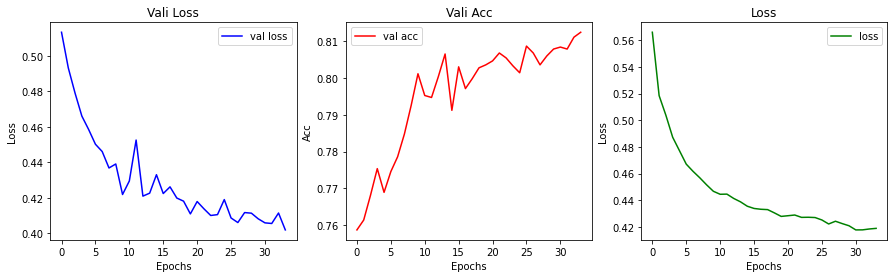

In [270]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].plot(history.history['val_loss'], color='b', label="val loss")
axes[0].set_title("Vali Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history.history['val_accuracy'], color='r', label="val acc")
axes[1].set_title("Vali Acc")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Acc")
axes[1].legend()

axes[2].plot(history.history['loss'], color='green', label="loss")
axes[2].set_title("Loss")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.show()

In [271]:
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis = 1)
result = pd.Series(pred_classes, name="Label")

In [272]:
pred

array([[0.3667293 , 0.63327074],
       [0.6152833 , 0.3847167 ],
       [0.7352646 , 0.2647354 ],
       ...,
       [0.32185546, 0.6781445 ],
       [0.79942477, 0.2005752 ],
       [0.6555889 , 0.34441105]], dtype=float32)

In [273]:
pred_classes.sum()

1193

In [274]:
result

0       1
1       0
2       0
3       1
4       0
       ..
5995    0
5996    0
5997    1
5998    0
5999    0
Name: Label, Length: 6000, dtype: int64

In [276]:
f1_ANN = f1_score(y_test, pred_classes)
print(f"f1 score for Artificial Neural Network: {f1_ANN:.3f}")

0.508336722244815

In [277]:
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4734
           1       0.52      0.49      0.51      1266

    accuracy                           0.80      6000
   macro avg       0.70      0.69      0.69      6000
weighted avg       0.79      0.80      0.80      6000



## **4.5 XGBoost**

### 4.5.1 Data Preparation

In [142]:
# set up validation set - aim for train:val = 3:1
Xtrain, Xval, ytrain, yval = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('Training set:', len(ytrain))
print('Validation set:', len(yval))
print('Training/Validation:', len(ytrain)/len(yval))

Training set: 18000
Validation set: 6000
Training/Validation: 3.0


In [143]:
# create DMatrix
DTrain = xgb.DMatrix(Xtrain, label=ytrain)
DVal = xgb.DMatrix(Xval, label=yval)
DTest = xgb.DMatrix(x_test, label=y_test)

### 4.5.2 Model Training

In [147]:
# Baseline model: hyperparameters with default values
params = {
    # parameters for tree booster with default values
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    # other parameters
    'scale_pos_weight': 3.5180722891566263, # comments
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' # default for classification task
}

In [157]:
# train the baseline model
xgb0 = xgb.train(
    params,
    DTrain,
    num_boost_round=1000,
    evals=[(DVal, 'valid')],
    early_stopping_rounds=10
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb0.best_score, xgb0.best_iteration+1))

[0]	valid-logloss:0.629996
Will train until valid-logloss hasn't improved in 10 rounds.
[1]	valid-logloss:0.594123
[2]	valid-logloss:0.573664
[3]	valid-logloss:0.561353
[4]	valid-logloss:0.552807
[5]	valid-logloss:0.547466
[6]	valid-logloss:0.543771
[7]	valid-logloss:0.54108
[8]	valid-logloss:0.539003
[9]	valid-logloss:0.537715
[10]	valid-logloss:0.53666
[11]	valid-logloss:0.534924
[12]	valid-logloss:0.534944
[13]	valid-logloss:0.535172
[14]	valid-logloss:0.535152
[15]	valid-logloss:0.535003
[16]	valid-logloss:0.53459
[17]	valid-logloss:0.532848
[18]	valid-logloss:0.532792
[19]	valid-logloss:0.532258
[20]	valid-logloss:0.531489
[21]	valid-logloss:0.531096
[22]	valid-logloss:0.530983
[23]	valid-logloss:0.529984
[24]	valid-logloss:0.53017
[25]	valid-logloss:0.529885
[26]	valid-logloss:0.529412
[27]	valid-logloss:0.528597
[28]	valid-logloss:0.52782
[29]	valid-logloss:0.526888
[30]	valid-logloss:0.526735
[31]	valid-logloss:0.526466
[32]	valid-logloss:0.526259
[33]	valid-logloss:0.526183
[3

In [158]:
# prediction
y_pred_xgboost = [int(round(value)) for value in xgb0.predict(DTest)]

In [159]:
# Obtain the f1 score and report for three methods
f1_xgboost = f1_score(y_test, y_pred_xgboost)
print(f"f1 score for XGBoost: {f1_xgboost:.3f}")

f1 score for XGBoost: 0.514


In [161]:
print(classification_report(y_test, y_pred_xgboost))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4734
           1       0.49      0.54      0.51      1266

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.69      6000
weighted avg       0.79      0.78      0.79      6000



# **5. Model Training & Validation**

We chose XGBoost as our final methodology. This section contains the step-by-step model training and hyperparameter tuning for our final optimal XGBoost model.

### 5.1 Set up XGBoost Classification model

In [86]:
params = {
    # parameters for tree booster with default values (to be tuned)
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    # other parameters
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' # default for classification task
}

In [68]:
# global variable
NUM_BOOST_ROUND = 1000

**Some helper functions**

In [69]:
# gridsearch parameter set (for 2 parameters) using 5-fold cross validation with single evaluation metrix 'logloss'
def gridsearch_best_params(params_set, param1_name:str, param2_name:str, string_format, figwidth=10):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['params', 'test-logloss-mean', 'boost rounds'])
    
    for param1, param2 in params_set:
        print(string_format.format(param1, param2))
        # update parameters
        params[param1_name] = param1
        params[param2_name] = param2
        
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=NUM_BOOST_ROUND, # set up a large iteration, will stop early
            seed=42,
            nfold=5,
            metrics={'logloss'}, # default choice for classification task
            early_stopping_rounds=10)
        
        # write down the results
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        results = results.append({'params':"({},{})".format(param1, param2), 'test-logloss-mean':mean_logloss, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="params", y=["test-logloss-mean"], ax=ax[0], color='green')
    results.plot(x="params", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['params']) 
    fig.suptitle("Gridsearch CV for parameters tuning: {}, {}".format(param1_name, param2_name), fontsize=14)
    plt.show()
    
    print(results)

In [70]:
# gridsearch parameter set (for single parameter) using 5-fold cross validation with single evaluation metrix 'logloss'
def gridsearch_best_param(param_set, param_name:str, string_format, figwidth=10, convert_to_str=False, timed=False):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['param', 'test-logloss-mean', 'boost rounds'])
    
    for param in param_set:
        print(string_format.format(param))
        # update parameters
        params[param_name] = param
        
        if timed:
            start = time.time()
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=NUM_BOOST_ROUND,
            seed=42,
            nfold=5,
            metrics={'logloss'}, # default choice for classification task
            early_stopping_rounds=10)
        
        if timed:
            end = time.time()
            print ("Time used:", end - start)
        
        # write down the results
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        results = results.append({'param':param, 'test-logloss-mean':mean_logloss, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    if convert_to_str:
        results['param'] = results['param'].astype(str)
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="param", y=["test-logloss-mean"], ax=ax[0], color='green')
    results.plot(x="param", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['param'])
    fig.suptitle("Gridsearch CV for parameter tuning: {}".format(param_name), fontsize=14)
    plt.show()
    
    print(results)

### 5.2 Hyperparmeters Tuning

#### 5.2.1 Step 1: Tune max_depth and min_child_weight

CV with max_depth=3, min_child_weight=1
CV with max_depth=3, min_child_weight=3
CV with max_depth=3, min_child_weight=5
CV with max_depth=5, min_child_weight=1
CV with max_depth=5, min_child_weight=3
CV with max_depth=5, min_child_weight=5
CV with max_depth=7, min_child_weight=1
CV with max_depth=7, min_child_weight=3
CV with max_depth=7, min_child_weight=5
CV with max_depth=9, min_child_weight=1
CV with max_depth=9, min_child_weight=3
CV with max_depth=9, min_child_weight=5


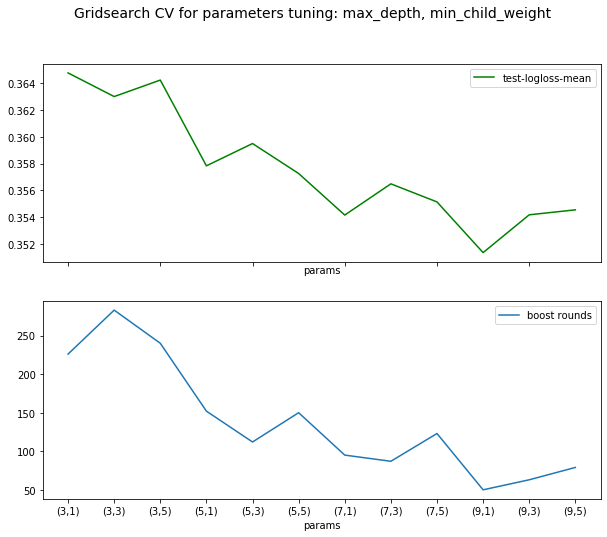

   params  test-logloss-mean boost rounds
0   (3,1)           0.364770          226
1   (3,3)           0.363003          283
2   (3,5)           0.364235          240
3   (5,1)           0.357830          152
4   (5,3)           0.359495          112
5   (5,5)           0.357257          150
6   (7,1)           0.354153           95
7   (7,3)           0.356485           87
8   (7,5)           0.355134          123
9   (9,1)           0.351348           50
10  (9,3)           0.354171           63
11  (9,5)           0.354543           79


In [71]:
# perform GridSearch on testing 12 combinations
param_test1 = [(max_depth, min_child_weight)
              for max_depth in range(3,10,2)
              for min_child_weight in range(1,6,2)]

gridsearch_best_params(param_test1, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}")

Choose (9,1) which has the lowest test-logloss-mean and a low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 1.

CV with max_depth=8, min_child_weight=1
CV with max_depth=8, min_child_weight=2
CV with max_depth=8, min_child_weight=3
CV with max_depth=9, min_child_weight=1
CV with max_depth=9, min_child_weight=2
CV with max_depth=9, min_child_weight=3
CV with max_depth=10, min_child_weight=1
CV with max_depth=10, min_child_weight=2
CV with max_depth=10, min_child_weight=3


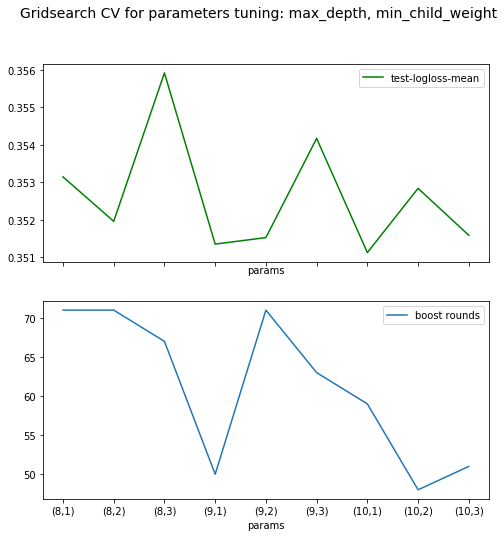

   params  test-logloss-mean boost rounds
0   (8,1)           0.353144           71
1   (8,2)           0.351956           71
2   (8,3)           0.355920           67
3   (9,1)           0.351348           50
4   (9,2)           0.351522           71
5   (9,3)           0.354171           63
6  (10,1)           0.351121           59
7  (10,2)           0.352838           48
8  (10,3)           0.351583           51


In [77]:
# test values in step 1, centred at (9,1)
param_test1b = [(max_depth, min_child_weight)
              for max_depth in [8,9,10]
              for min_child_weight in [1,2,3]]

gridsearch_best_params(param_test1b, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}", 8)

(10,1) is the optimal one.

In [78]:
# update optimal parameter values
params['max_depth'] = 10
params['min_child_weight'] = 1

### Step 2: Tune subsamples and colsample_bytree

CV with subsample=0.7, colsample_bytree=0.7
CV with subsample=0.7, colsample_bytree=0.8
CV with subsample=0.7, colsample_bytree=0.9
CV with subsample=0.7, colsample_bytree=1.0
CV with subsample=0.8, colsample_bytree=0.7
CV with subsample=0.8, colsample_bytree=0.8
CV with subsample=0.8, colsample_bytree=0.9
CV with subsample=0.8, colsample_bytree=1.0
CV with subsample=0.9, colsample_bytree=0.7
CV with subsample=0.9, colsample_bytree=0.8
CV with subsample=0.9, colsample_bytree=0.9
CV with subsample=0.9, colsample_bytree=1.0
CV with subsample=1.0, colsample_bytree=0.7
CV with subsample=1.0, colsample_bytree=0.8
CV with subsample=1.0, colsample_bytree=0.9
CV with subsample=1.0, colsample_bytree=1.0


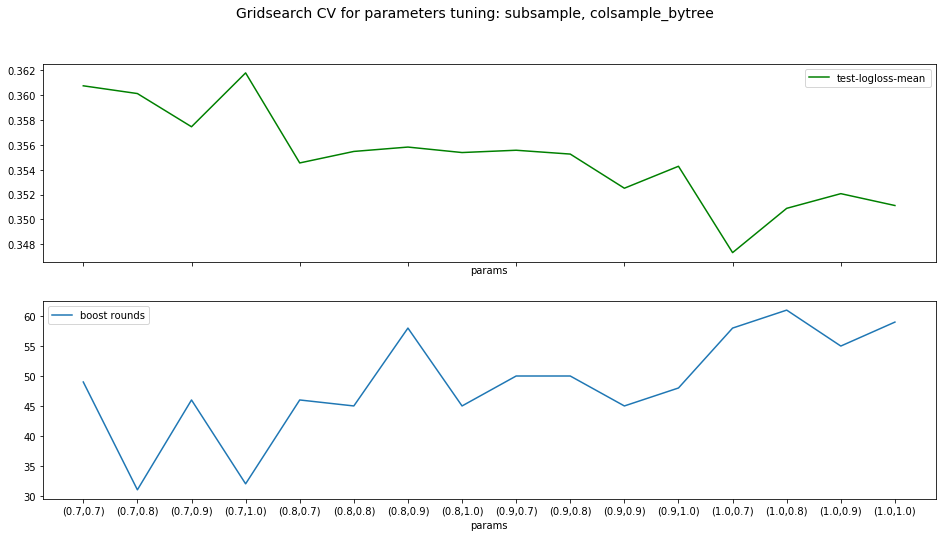

       params  test-logloss-mean boost rounds
0   (0.7,0.7)           0.360762           49
1   (0.7,0.8)           0.360139           31
2   (0.7,0.9)           0.357464           46
3   (0.7,1.0)           0.361802           32
4   (0.8,0.7)           0.354550           46
5   (0.8,0.8)           0.355477           45
6   (0.8,0.9)           0.355829           58
7   (0.8,1.0)           0.355388           45
8   (0.9,0.7)           0.355573           50
9   (0.9,0.8)           0.355264           50
10  (0.9,0.9)           0.352514           45
11  (0.9,1.0)           0.354282           48
12  (1.0,0.7)           0.347328           58
13  (1.0,0.8)           0.350895           61
14  (1.0,0.9)           0.352077           55
15  (1.0,1.0)           0.351121           59


In [79]:
# perform GridSearch on testing 16 combinations
param_test2 = [(subsample, colsample)
              for subsample in [i/10 for i in range(7,11)]
              for colsample in [i/10 for i in range(7,11)]]

gridsearch_best_params(param_test2, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 16)

(1.0,0.7) has the lowest test-logloss-mean but a relatively high boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.05.

CV with subsample=0.95, colsample_bytree=0.65
CV with subsample=0.95, colsample_bytree=0.7
CV with subsample=0.95, colsample_bytree=0.75
CV with subsample=1.0, colsample_bytree=0.65
CV with subsample=1.0, colsample_bytree=0.7
CV with subsample=1.0, colsample_bytree=0.75


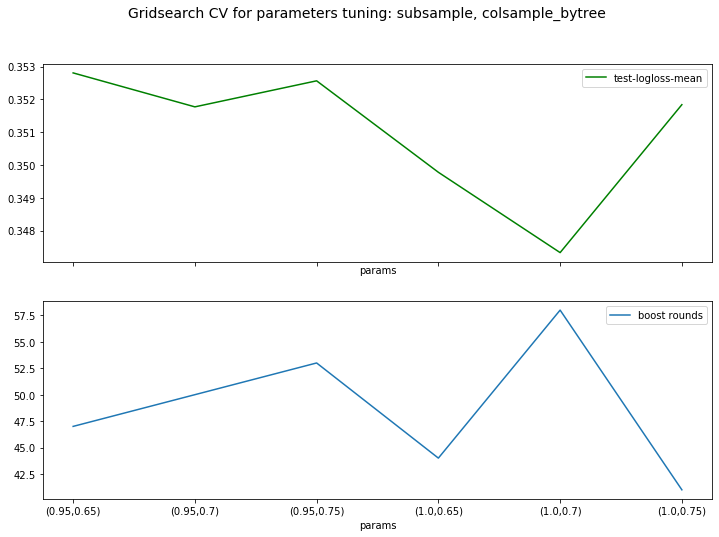

        params  test-logloss-mean boost rounds
0  (0.95,0.65)           0.352807           47
1   (0.95,0.7)           0.351772           50
2  (0.95,0.75)           0.352566           53
3   (1.0,0.65)           0.349777           44
4    (1.0,0.7)           0.347328           58
5   (1.0,0.75)           0.351839           41


In [80]:
# test values in step 0.05, centred at (1.0,0.7)
# note that 1.0 is the maximum value for 'subsample' and 'colsample_bytree'
param_test2b = [(subsample, colsample)
              for subsample in [i/100 for i in range(95,105,5)]
              for colsample in [i/100 for i in range(65,80,5)]]

gridsearch_best_params(param_test2b, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 12)

(1.0,0.7) is still the optimal one for test-logloss-mean, though it needs a high boost rounds.

In [81]:
# update optimal parameter values
params['subsample'] = 1.0
params['colsample_bytree'] = 0.7

### Step 3: Tune gamma

CV with gamma=0
CV with gamma=1
CV with gamma=2
CV with gamma=3
CV with gamma=4
CV with gamma=5
CV with gamma=6
CV with gamma=7
CV with gamma=8
CV with gamma=9
CV with gamma=10


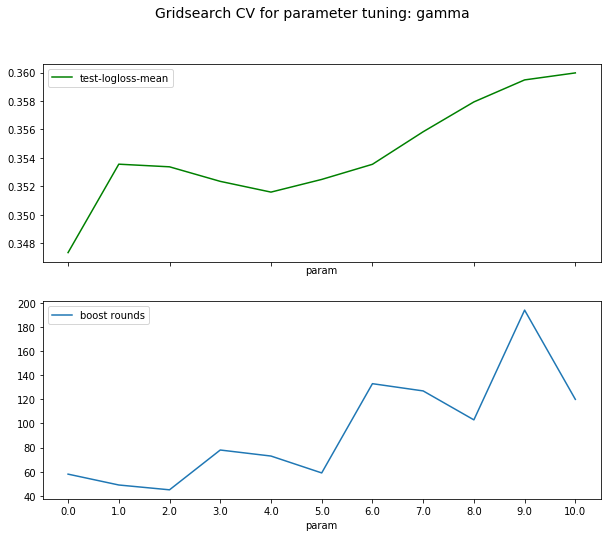

    param  test-logloss-mean  boost rounds
0     0.0           0.347328          58.0
1     1.0           0.353551          49.0
2     2.0           0.353365          45.0
3     3.0           0.352342          78.0
4     4.0           0.351586          73.0
5     5.0           0.352478          59.0
6     6.0           0.353543         133.0
7     7.0           0.355832         127.0
8     8.0           0.357931         103.0
9     9.0           0.359480         194.0
10   10.0           0.359973         120.0


In [82]:
# perform GridSearch on testing 11 values
param_test3 = [i for i in range(0,11)]

gridsearch_best_param(param_test3, 'gamma', "CV with gamma={}")

gamma = 0 has the lowest test-logloss-mean and a relatively low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.1.

CV with gamma=0.0
CV with gamma=0.1
CV with gamma=0.2
CV with gamma=0.3
CV with gamma=0.4
CV with gamma=0.5
CV with gamma=0.6
CV with gamma=0.7
CV with gamma=0.8
CV with gamma=0.9
CV with gamma=1.0


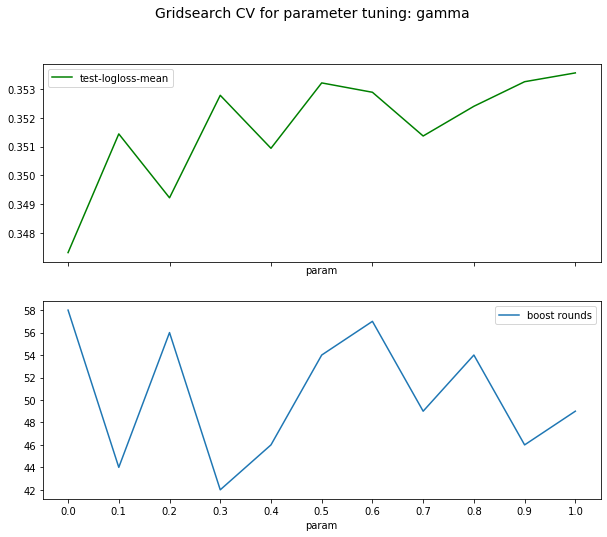

   param  test-logloss-mean  boost rounds
0    0.0           0.347328          58.0
1    0.1           0.351439          44.0
2    0.2           0.349226          56.0
3    0.3           0.352775          42.0
4    0.4           0.350940          46.0
5    0.5           0.353204          54.0
6    0.6           0.352880          57.0
7    0.7           0.351366          49.0
8    0.8           0.352395          54.0
9    0.9           0.353246          46.0
10   1.0           0.353551          49.0


In [83]:
# test values in step 0.1, centred at (0.0)
param_test3b = [i/10 for i in range(0,11)]

gridsearch_best_param(param_test3b, 'gamma', "CV with gamma={}", convert_to_str=True)

gamma = 0 is still the optimal one.

In [84]:
# update optimal parameter value
params['gamma'] = 0

### Step 4: Tune regularisation parameters - alpha, lambda

CV with alpha=1e-05
CV with alpha=0.0001
CV with alpha=0.001
CV with alpha=0.01
CV with alpha=0.1
CV with alpha=1
CV with alpha=10
CV with alpha=50
CV with alpha=100


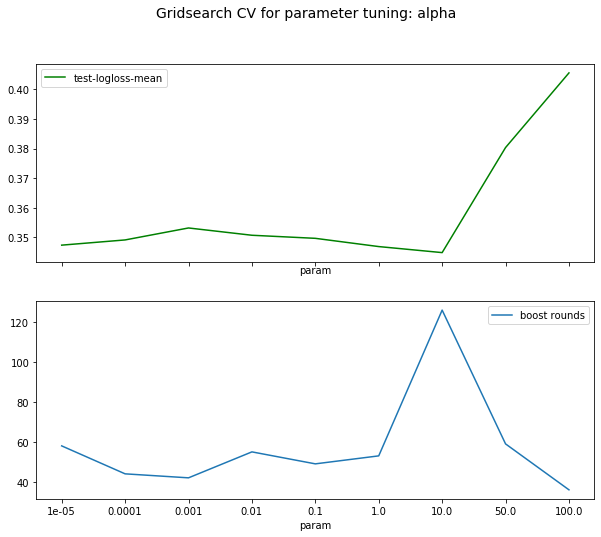

    param  test-logloss-mean  boost rounds
0   1e-05           0.347328          58.0
1  0.0001           0.349091          44.0
2   0.001           0.353137          42.0
3    0.01           0.350673          55.0
4     0.1           0.349633          49.0
5     1.0           0.346845          53.0
6    10.0           0.344805         126.0
7    50.0           0.380332          59.0
8   100.0           0.405573          36.0


In [85]:
# select 9 values from a broad range, perform GridSearch on testing these 9 values for 'alpha'
param_test4_alpha = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

The lower the alpha, the lower the test-logloss-mean. Therefore, it'd better to keep alpha as its default value: 0.

In [ ]:
# update optimal parameter value
params['alpha'] = 0     # the default value

In [ ]:
# select 9 values from a broad range, perform GridSearch on testing 9 values for 'lambda'
param_test4_lambda = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

The higher the lambda, the lower the test-logloss-mean. Take a closer look at values between 0.1 and 50. 

In [ ]:
# test values between 0.1 and 50
param_test4b_lambda = [0.1, 0.3, 0.6, 0.9, 1, 3, 6, 9, 10, 20, 30, 40, 50]

gridsearch_best_param(param_test4b_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 20 has the lowest the test-logloss-mean. This is a relatively high lambda value, with the risk of underfitting the model. But let's consider it as the optimal at the moment.
<br>
Need to check values around 20 in a smaller step.

In [ ]:
# test values around 20 in step 1
param_test4c_lambda = [i for i in range(15,26,1)]

gridsearch_best_param(param_test4c_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 21 is the optimal one.

In [ ]:
# update optimal parameter value
params['lambda'] = 21

### Step 5: Reduce learning rate

In [ ]:
# perform GridSearch on testing 5 values for eta
param_test5 = [1, .1, .05, .01, .005]

# timing
%time gridsearch_best_param(param_test5, 'eta', "CV with eta={}", convert_to_str=True, timed=True)

eta = 0.05 has lowest test-logloss-mean but a high boost rounds (429 rounds). However, it didn't take a long time to run (83 seconds). Hence, we can consider 0.05 as the optimal.

In [ ]:
# update best parameter
params['eta'] = 0.05

# **6. Results**

In [277]:
# tuned hyperparameters values
params

# compared with default values:
# 'max_depth': 6,
# 'min_child_weight': 1,
# 'eta': 0.3,
# 'subsample': 1,
# 'colsample_bytree': 1,
# 'gamma': 0,
# 'alpha': 0,
# 'lambda': 1,

In [ ]:
# feed in parameters to find optimal 'num_boost_round'
xgb1 = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')],
    early_stopping_rounds=10
)

print("Lowest logloss for validation set: {} with {} rounds".format(xgb1.best_score, xgb1.best_iteration+1))

In [ ]:
# remove the early_stopping_rounds since we've got the exact optimal num_boost_round
NUM_BOOST_ROUND = xgb1.best_iteration + 1

optimal_model = xgb.train(
    params,
    DTrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(DVal, 'valid')]
)

In [ ]:
# save model
path = '' # change to your local directory
optimal_model.save_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')

# **7. Final Predictions on Test Set**